# Scaling monosemanticity

In [ ]:
# Required installations for transformers and datasets
!pip install transformers datasets
!pip install keras huggingface_hub
!pip install tensorflow
!pip install python-dotenv
!pip install zstandard
#!pip install bitsandbytes

In [1]:
import os
import time
from dotenv import load_dotenv
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
from huggingface_hub import login
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from transformers import BitsAndBytesConfig

2024-11-25 09:39:45.157129: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732523985.252039    8059 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732523985.279208    8059 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-25 09:39:45.512742: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Transformer activations - LLaMA 3.2 3B

In [2]:
load_dotenv()
hf_token = os.getenv("HF_TOKEN")
login(token=hf_token)

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /home/drew99/.cache/huggingface/token
Login successful


In [ ]:

# Load the LLaMA 3.2B model without quantization (for now)
model_name = "meta-llama/Llama-3.2-3B"
device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
# model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16).to(device) # 16-bit precision

# Some other LLaMA models to try:
# https://huggingface.co/meta-llama/Llama-3.2-3B"
# https://huggingface.co/meta-llama/Llama-3.2-3B-Instruct-QLORA_INT4_EO8
# https://huggingface.co/mradermacher/Fireball-Meta-Llama-3.2-8B-Instruct-agent-003-128k-code-DPO-i1-GGUF  i1-Q4_K_M
# https://huggingface.co/TheBloke/Llama-2-7B-Chat-GPTQ

# Prepare 4-bit quantization configuration (optional)
# Uncomment the following lines if you wish to use quantization
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)
model = AutoModelForCausalLM.from_pretrained(model_name, quantization_config=bnb_config).to(device)


In [7]:
activation_cache = []
def save_activations_hook(module, input, output):
    # input is a tuple; input[0] is the tensor we need
    activation_cache.append(input[0].cpu().detach().numpy())

# Register hook on the 16th layer
layer_index = 15  # Zero-based index; 15 corresponds to the 16th layer
hook_handle = model.model.layers[layer_index].register_forward_hook(save_activations_hook) 
# for other models, you may need to use model.transformer.h[15] instead of model.model.layers[15]


In [ ]:
## Loop through dataset, get activations from middle layer, and save to file

# # Load the first 30 million examples from 'The Pile' dataset 
# # https://huggingface.co/docs/datasets/loading#slice-splits
# # data_len = 30_000_000
# data_len = 30_000
# # split_str = f"train[:{data_len}]"
# dataset = load_dataset("monology/pile-uncopyrighted", split="train", streaming=True)

# # Set up processing parameters
# os.makedirs("activations_data", exist_ok=True)

# # Initialize accumulators and parameters
# batch_size = 8 # number of sentences in a batch
# file_size = 10*8192 # number of examples in a file
# files_saved = 0
# batch_texts = []
# activation_cache = [] # cache of activations for a batch
# all_data = np.empty((0, 3075), dtype=np.float16)  # 3072 + 3 (sent_idx, token_idx, token)

# # Create batches from the dataset
# print("Processing dataset and saving activations in batches...")
# for i, example in enumerate(dataset):
#     batch_texts.append(example['text'])
    
#     if (i + 1) % batch_size == 0 or i + 1 >= data_len:
#         # Process full batch or final partial batch
#         inputs = tokenizer(
#             batch_texts,
#             return_tensors="pt",
#             truncation=True,
#             max_length=512,
#             padding="max_length",
#         ).to(device)
        
#         with torch.no_grad():
#             model(**inputs)
        
#         # Convert activation_cache to numpy array and reshape
#         batch_activations = np.array(activation_cache)
        
#         # Reshape batch_activations from (1, 8, 42, 3072) to (8*42, 3072)
#         batch_activations = batch_activations.reshape(batch_activations.shape[1] * batch_activations.shape[2], -1)

#         # Create sentence index array (sent_idx) and token index array (token_idx)
#         # sent_idx = [1 1 1 1 1; 2 2 2 2 2; 3 3 3 3 3; ...]
#         # token_idx = [1 2 3 4 5; 1 2 3 4 5; 1 2 3 4 5; ...]
#         num_sentences, num_tokens = inputs['attention_mask'].shape # (8, 42)
#         sent_idx = np.repeat(np.arange(1, num_sentences + 1), num_tokens).reshape(-1, 1)  # Shape: (8*42, 1)
#         sent_idx = sent_idx + (i - batch_size) # offset by batch index
#         token_idx = np.tile(np.arange(1, num_tokens + 1), num_sentences).reshape(-1, 1)    # Shape: (8*42, 1)
#         token_idx = token_idx - 1 # offset by 1
#         # also save tokens id from tokenizer
#         tokens = inputs['input_ids'].cpu().numpy().reshape(-1, 1)
#         tokens = tokens-64000 # offset by 64000 to not overflow float16
                
#         # Stack activations, sent_idx, and token_idx
#         batch_activations = np.hstack((batch_activations, sent_idx, token_idx, tokens)).astype(np.float16)

#         # Remove rows where attention mask is 0
#         attention_mask = inputs['attention_mask'].cpu().numpy().reshape(-1)
#         batch_activations = batch_activations[attention_mask != 0]

#         # Stack to all_data
#         all_data = np.vstack((all_data, batch_activations))
#         print(f"all_data shape: {all_data.shape}")

#         # Save to file if file_size limit is reached
#         if all_data.shape[0] >= file_size:
#             data_to_save = all_data[:file_size, :]
#             np.save(f"activations_data/activations_batch_{files_saved:04d}.npy", data_to_save)
#             files_saved += 1
#             print(f"Saved file {files_saved} == {file_size*files_saved} examples")
#             all_data = all_data[file_size:, :]  # Retain any remaining rows
            
#         # Reset for next batch
#         batch_texts = []
#         activation_cache = []

#     if i + 1 >= data_len:
#         break

# # Save any remaining data
# if all_data.shape[0] > 0:
#     np.save(f"activations_data/activations_batch_{files_saved:04d}.npy", all_data)
#     del all_data

# print("Finished processing and saving all batches")



In [11]:
## Clean up
# # Unregister hook
# hook_handle.remove()
# # Shutdown the model use del and free gpu
# del model
# del tokenizer
# torch.cuda.empty_cache()
# print("Model deleted and GPU memory freed")


Model deleted and GPU memory freed


In [3]:
# scale_factor = 34.12206415510119 # at 1.6mil tokens
scale_factor = 34.128712991170886 # at 10.6mil tokens

In [4]:
class SparseAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(SparseAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Linear(input_dim, hidden_dim)
        # Decoder
        self.decoder = nn.Linear(hidden_dim, input_dim)
        
    def forward(self, x):
        encoded = torch.relu(self.encoder(x))
        # encoded = torch.nn.LeakyReLU(0.01)(self.encoder(x))
        decoded = self.decoder(encoded)
        return decoded, encoded


In [5]:
from torch.utils.data import Dataset, DataLoader
class ActivationDataset(Dataset):
    def __init__(self, data_dir, batch_size, f_type, test_fraction=0.01, scale_factor=1.0, seed=42):
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.seed = seed

        if f_type in ["train", "test", "all"]:
            self.f_type = f_type
        else:
            raise ValueError("f_type must be 'train' or 'test' or 'all'")
        
        if not 0 <= test_fraction <= 1:
            raise ValueError("test_fraction must be between 0 and 1")
        self.test_fraction = test_fraction

        self.scale_factor = scale_factor
        self.file_names = sorted([f for f in os.listdir(data_dir) if f.endswith('.npy') and f.startswith('activations_batch')])
        
        split_idx = int(len(self.file_names) * (1 - test_fraction))
        if f_type == "train":
            self.file_names = self.file_names[:split_idx]
        elif f_type == "test":
            self.file_names = self.file_names[split_idx:]
        else: # all
            pass

        print(f"Loaded {len(self.file_names)} batches for {f_type} set")

    def __len__(self):
        return len(self.file_names)
    
    def __getitem__(self, idx):
        file_path = os.path.join(self.data_dir, self.file_names[idx])
        activations = np.load(file_path)
        if self.f_type == "all":
            sent_idx = activations[:, -3]
            token_idx = activations[:, -2] 
            token = activations[:, -1]
        # remove last 3 columns (sent_idx, token_idx, and token)
        activations = activations[:, :-3]
        # normalize activations
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        activations = torch.tensor(activations, dtype=torch.float32, device=device)
        # print("Activation Range Before Normalization:", torch.min(activations).item(), torch.max(activations).item())
        activations = activations / self.scale_factor * np.sqrt(activations.shape[1])
        # print("Activation Range After Normalization:", torch.min(activations).item(), torch.max(activations).item())

        if self.f_type == "train":
            # Set seed for reproducibility
            np.random.seed(self.seed)
            # random subsample 8192 examples
            indices = torch.randperm(activations.shape[0], device=activations.device)[:self.batch_size]
            activations = activations[indices]
        
        if self.f_type == "all":
            return activations, sent_idx, token_idx, token
        else:
            return activations



In [9]:
# clear gpu
del model
del data_loader
del dataset
del criterion
del optimizer
del batch
import gc
gc.collect()
torch.cuda.empty_cache()
print("Model deleted and GPU memory freed")

Model deleted and GPU memory freed


In [5]:
data_dir = "activations_data"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_dim = 3072  
hidden_dim = 20000 # = 4096  # Adjust based on your requirements


In [6]:
model = SparseAutoencoder(input_dim, hidden_dim).to(device)
model.load_state_dict(torch.load("models/sparse_autoencoder_tmp.pth"))

criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
l1_lambda = 0.01  # Regularization strength for sparsity


## Analysis of latent vectors

In [ ]:
## Update token column in latent vectors

# import glob
# import numpy as np
# import torch

# # Get all activation batch files and corresponding latent vector files
# activation_files = sorted(glob.glob("activations_data/activations_batch_*.npy"))
# latent_vector_files = sorted(glob.glob("sparse_latent_vectors/latent_vectors_batch_*_minibatch_*.pt"))

# # Process each batch
# for activation_file in activation_files:
#     batch_num = activation_file.split("batch_")[1].split(".")[0]
#     batch_num = int(batch_num)
#     print(f"Processing batch {batch_num}")
#     loaded_activations = np.load(activation_file)
#     activations_metadata = loaded_activations[:,-3:]  # Get last 3 columns
    
#     # Find corresponding latent vector files for this batch
#     batch_latent_files = [f for f in latent_vector_files if f"batch_{batch_num}_" in f]
    
#     for latent_file in batch_latent_files:
#         # Extract minibatch number from filename
#         minibatch_num = int(latent_file.split("minibatch_")[1].split(".")[0])
        
#         # Load latent vectors for this minibatch
#         loaded_latent_vectors = torch.load(latent_file)
#         latent_metadata = loaded_latent_vectors[:,-3:].cpu().numpy()

#         # Select corresponding rows from activations based on minibatch
#         minibatch_size = loaded_latent_vectors.shape[0]
#         start_idx = minibatch_num * minibatch_size
#         end_idx = start_idx + minibatch_size
#         activations_minibatch = activations_metadata[start_idx:end_idx]

#         # Check if sent_idx and token_idx match for this minibatch
#         if not np.array_equal(activations_minibatch[:,:-1], latent_metadata[:,:-1]):
#             raise ValueError(f"sent_idx and token_idx do not match between {activation_file} and {latent_file}")
#         # else:
#         #     print(f"sent_idx and token_idx match between {activation_file} and {latent_file}")

#         # Update token column in latent vectors
#         loaded_latent_vectors[:,-1] = torch.tensor(activations_minibatch[:,-1], device=loaded_latent_vectors.device)
        
#         # Save updated latent vectors
#         torch.save(loaded_latent_vectors, latent_file)


In [ ]:
## Check for inf values in token column - float16 overflow
# import numpy as np
# import glob
# for batch_file in glob.glob("activations_data/activations_batch_*.npy"):
#     batch_vectors = np.load(batch_file)
#     print(f"Batch {batch_file}: {np.sum(np.isinf(batch_vectors[:,-1]))} inf values in token column")

In [7]:
## Convert latent vectors to float16
# # Load and check min/max values for all latent vector files
# latent_vector_files = sorted(glob.glob("sparse_latent_vectors/latent_vectors_batch_*.pt"))

# for latent_file in latent_vector_files:
#     loaded_vectors = torch.load(latent_file)
#     loaded_vectors = loaded_vectors.to(torch.float16)  # Convert to float16
#     torch.save(loaded_vectors, latent_file)  # Save back to same file
#     # min_val = loaded_vectors.min().item()
#     # max_val = loaded_vectors.max().item()
#     # # print(f"{latent_file}:")
#     # # print(f"  Min value: {min_val:.6f}")
#     # # print(f"  Max value: {max_val:.6f}")
#     # print(min_val, max_val)


In [ ]:
## fix last 3 columns in activations, save them to int32 file

# import glob
# import numpy as np
# from datasets import load_dataset
# from transformers import AutoTokenizer

# # Load tokenizer
# model_name = "meta-llama/Llama-3.2-3B"
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# tokenizer.pad_token = tokenizer.eos_token

# # Load dataset and numpy files
# files = sorted(glob.glob("activations_data/activations_batch_*.npy"))
# dataset = load_dataset("monology/pile-uncopyrighted", split="train", streaming=True)

# # Initialize variables
# file_index = 0
# numpy_data = np.load(files[file_index])
# row_index = 0  # Index for traversing rows within a numpy file
# last_3_columns = []  # Store last 3 columns to save in a separate file

# # Function to save current numpy_data and load the next file
# def save_and_load_next():
#     global file_index, numpy_data, row_index, last_3_columns
#     # Save original activations
#     np.save(files[file_index], numpy_data)
#     # Save the last 3 columns in a separate int32 file
#     last_3_columns_file = files[file_index].replace("/activations_", "/last3_")
#     np.save(last_3_columns_file, np.array(last_3_columns, dtype=np.int32))
#     last_3_columns = []  # Reset for the next batch
#     # Load the next file
#     file_index += 1
#     if file_index < len(files):
#         numpy_data = np.load(files[file_index])
#         row_index = 0
#         print(f"Processing file {files[file_index]}")
#     else:
#         numpy_data = None  # No more files to process

# # Process dataset
# for i, example in enumerate(dataset):
#     if numpy_data is None:
#         break  # Exit if no more files

#     # Extract and tokenize the current dataset example
#     tok_text = tokenizer(
#         example['text'],
#         return_tensors="pt",
#         truncation=True,
#         max_length=512,
#         padding="max_length",
#     )
#     tok_text = tok_text['input_ids'].squeeze().cpu().numpy()

#     # Match `sent_idx` and update tokens
#     while numpy_data is not None and row_index < len(numpy_data) and numpy_data[row_index, -3] == i:
#         token_idx = int(numpy_data[row_index, -2])  # Get token index (0-based)
#         if token_idx < len(tok_text):
#             # Save scaled token in the original file
#             numpy_data[row_index, -1] = (tok_text[token_idx] / 128.0).astype(np.float16)
#             # Save the unscaled last 3 columns
#             last_3_columns.append(
#                 [int(numpy_data[row_index, -3]),  # sent_idx
#                  int(numpy_data[row_index, -2]),  # token_idx
#                  int(tok_text[token_idx])]       # original token
#             )
#         else:
#             print(f"Warning: Token index {token_idx} out of bounds for sentence {i}")
#         row_index += 1
#         if row_index >= len(numpy_data):
#             save_and_load_next()

#     # If the current sentence spans into the next file
#     while numpy_data is not None and row_index < len(numpy_data) and numpy_data[row_index, -3] == i:
#         token_idx = int(numpy_data[row_index, -2])  # Get token index (0-based)
#         if token_idx < len(tok_text):
#             # Save scaled token in the original file
#             numpy_data[row_index, -1] = (tok_text[token_idx] / 128.0).astype(np.float16)
#             # Save the unscaled last 3 columns
#             last_3_columns.append(
#                 [int(numpy_data[row_index, -3]),  # sent_idx
#                  int(numpy_data[row_index, -2]),  # token_idx
#                  int(tok_text[token_idx])]       # original token
#             )
#         else:
#             print(f"Warning: Token index {token_idx} out of bounds for sentence {i}")
#         row_index += 1
#         if row_index >= len(numpy_data):
#             save_and_load_next()

# # Save the last file if needed
# if numpy_data is not None:
#     np.save(files[file_index], numpy_data)
#     last_3_columns_file = files[file_index].replace("/activations_", "/last3_")
#     np.save(last_3_columns_file, np.array(last_3_columns, dtype=np.int32))

# print("Finished updating token values in all files.")


In [ ]:
## sanity check for last3 files

# import numpy as np
# act_data = np.load("activations_data/activations_batch_0000.npy")
# print(act_data.shape)
# print(act_data[:10, -3:])
# # print((act_data[:10, -1]*128).astype(np.int32))
# # print(tokenizer.decode((act_data[:10, -1]*128).astype(np.int32).tolist()))
# scaled_tokens = (act_data[:20, -1].astype(np.float32) * 128.0).astype(np.int32)
# print(scaled_tokens)
# print(tokenizer.decode(scaled_tokens.tolist()))

# last3_data = np.load("activations_data/last3_batch_0000.npy")
# print(last3_data.shape)
# print(last3_data[:10])
# print(tokenizer.decode(last3_data[:20, -1].tolist()))


In [ ]:
## tokenize-encode-decode test

# dataset = load_dataset("monology/pile-uncopyrighted", split="train", streaming=True)
# for i, example in enumerate(dataset):
#     if i < 1:
#         print(example['text'][:1000])
#         print(tokenizer(example['text'])["input_ids"][:100])

#         tok_text = tokenizer(
#             example['text'],
#             return_tensors="pt",
#             truncation=True,
#             max_length=512,
#             padding="max_length",
#         )
#         tok_text = tok_text['input_ids'].squeeze().cpu().numpy()
#         print(tok_text[:100])
#     else:
#         break

In [2]:

# Load and examine saved latent vectors
import torch
import numpy as np

loaded_latent_vectors = torch.load("sparse_latent_vectors/latent_vectors_batch_0_minibatch_0.pt")
loaded_latent_vectors = loaded_latent_vectors.cpu().numpy()
print(f"Loaded sparse latent vectors shape: {loaded_latent_vectors.shape}")
print(loaded_latent_vectors.dtype)
print(loaded_latent_vectors.nbytes / 1e9, "GB")
# Could potentially load 10k batches (0.0002048 GB per batch) if we keep latent vector size 512
# So for emb size 1M , we could load only 5 batches at a time
print(loaded_latent_vectors[:,:-3].min(), loaded_latent_vectors[:,:-3].max())

# Sparsity check
# Calculate percent of zeros in each row by dividing by number of columns
num_cols = loaded_latent_vectors[:,:-3].shape[1]
sparsity = np.mean(np.sum(np.abs(loaded_latent_vectors[:,:-3]) < 1e-5, axis=1) / num_cols)
print(f"Average percent of zeros per latent vector: {sparsity:.2%}")

# Dead/active features check
# percent of columns that are all close to 0
dead_features = np.mean(np.all(np.abs(loaded_latent_vectors[:,:-3]) < 1e-5, axis=0))
print(f"Percent of dead features: {dead_features:.2%}")



Loaded sparse latent vectors shape: (8192, 20003)
float16
0.327729152 GB
0.0 210.2
Average percent of zeros per latent vector: 99.71%
Percent of dead features: 29.72%


In [ ]:
import numpy as np
import glob

a_files = sorted(glob.glob("activations_data/activations_batch_*.npy"))[:8]
activ = None; token_sent = None
for i, a_file in enumerate(a_files):
    print(f"Processing {a_file}")
    if activ is None:
        activ = np.load(a_file)
        token_sent = np.load(a_file.replace("/activations", "/last3"))
    else:
        activ = np.vstack((activ, np.load(a_file)))
        token_sent = np.vstack((token_sent, np.load(a_file.replace("/activations", "/last3"))))


In [3]:

# activ = np.load("activations_data/activations_batch_0000.npy")
# token_sent = np.load("activations_data/last3_batch_0000.npy")

# Get max value of each column
max_v = activ[:, :-3].max(axis=0)
min_v = activ[:, :-3].min(axis=0)

# Get indexes of columns with max value >= 10.0
# valid_i = np.where((max_v >= 5.0) & (max_v < 400.0))[0]
# above 5 or below -5
valid_i_max = np.where((max_v >= 8.0))[0]
valid_i_min = np.where((min_v <= -8.0))[0]

# Print indexes and corresponding max values
for idx in valid_i_max:
    print(f"Index: {idx}, Max Value: {max_v[idx]}")

print()
for idx in valid_i_min:
    print(f"Index: {idx}, Min Value: {min_v[idx]}")

Index: 588, Max Value: 332.25
Index: 1935, Max Value: 8.6875
Index: 1947, Max Value: 9.53125
Index: 3039, Max Value: 9.484375

Index: 1016, Min Value: -303.5
Index: 1659, Min Value: -25.375
Index: 1731, Min Value: -265.5
Index: 2898, Min Value: -8.8515625
Index: 3046, Min Value: -295.5


In [5]:
import pandas as pd
a_feat_idx = 3039

# get sent_idx and token_idx where feat_idx value is max
feat_idx = activ[:, a_feat_idx]
# max_feat_idx = np.argmax(feat_idx)
# max_feat_idx = np.argmin(feat_idx)
max_feat_idx20 = np.argsort(np.abs(feat_idx))[-10:]
for idx in max_feat_idx20:
    print(f"Index: {idx}, Value: {feat_idx[idx]}, File: {idx//81920}")
    sent_idx = activ[idx, -3]
    token_idx = activ[idx, -2]
    # token = activ[max_feat_idx, -1]

    # Get context +/- 15 tokens
    c = np.where((token_sent[:, -3] == sent_idx) & (token_sent[:, -2] >= token_idx - 15) & (token_sent[:, -2] <= token_idx + 15))
    context = token_sent[c]

    # tokenizer decode last col of context
    print(tokenizer.decode(context[:, -1]))
    tokens = tokenizer.convert_ids_to_tokens(context[:, -1])
    tokens = [t.replace("Ġ", "") for t in tokens]

    # into pandas and print coolwarm
    df = pd.DataFrame({
        'Token': tokens,
        'Activation': feat_idx[c]
    })

    v_max = np.max(np.abs(df['Activation']))

    # Display DataFrame with color gradient based on activation values
    display(df.style.background_gradient("coolwarm", vmin=-v_max, vmax=v_max))


Index: 137692, Value: 8.484375, File: 1
0 to become the first commercial sperm bank in the United States located in New Jersey.

BioGenetics respects the current medical standards and ethics set forth by the


,Token,Activation
0,0,4.359375
1,to,4.593750
2,become,3.355469
3,the,4.351562
4,first,3.640625
5,commercial,4.199219
6,sperm,5.269531
7,bank,3.890625
8,in,3.859375
9,the,3.705078


Index: 309995, Value: 8.4921875, File: 3
as Island, is a small (6 km²) island in Costa Rica in the vicinity of Quepos.  It is particularly noted for its est


,Token,Activation
0,as,1.892578
1,Island,5.140625
2,",",3.677734
3,is,3.365234
4,a,4.718750
5,small,4.453125
6,(,3.878906
7,6,3.613281
8,Âł,4.175781
9,km,2.771484


Index: 502762, Value: 8.546875, File: 6
 Trail is more used from and around the suspension bridge through the town of Pinawa

User Reviews (1)

Showing 1-1 of 1




,Token,Activation
0,Trail,3.867188
1,is,4.828125
2,more,3.460938
3,used,3.011719
4,from,1.832031
5,and,1.789062
6,around,3.148438
7,the,4.226562
8,suspension,2.312500
9,bridge,5.734375


Index: 118203, Value: 8.5625, File: 1
<|begin_of_text|>The establishment of a radioactive waste disposal facility in Western Australia for low level waste.
The Radiation Health Section of the Health Department of Western


,Token,Activation
0,<|begin_of_text|>,-7.265625
1,The,2.958984
2,establishment,3.376953
3,of,3.648438
4,a,4.394531
5,radioactive,4.000000
6,waste,5.753906
7,disposal,4.695312
8,facility,5.085938
9,in,4.769531


Index: 62670, Value: 8.7265625, File: 0
 example input value for user to see

I want to create automated cells in Excel which will show the type of data to be entered in that cells. I


,Token,Activation
0,example,3.826172
1,input,5.238281
2,value,4.843750
3,for,4.062500
4,user,3.626953
5,to,4.242188
6,see,3.443359
7,ĊĊ,2.355469
8,I,3.585938
9,want,4.195312


Index: 601664, Value: 8.84375, File: 7
<|begin_of_text|>Q:

How to access drives other than C: in Ubuntu on Windows

In the Windows Subsystem for Linux, I can access the


,Token,Activation
0,<|begin_of_text|>,-7.265625
1,Q,2.695312
2,:ĊĊ,1.986328
3,How,3.464844
4,to,3.511719
5,access,4.480469
6,drives,6.875000
7,other,3.070312
8,than,4.476562
9,C,6.703125


Index: 326520, Value: 8.875, File: 3
born 1978) is an American artist who lives and works in Los Angeles, California. Her abstract paintings are grounded in representation.

Early life and education


,Token,Activation
0,born,1.626953
1,,2.121094
2,197,3.150391
3,8,1.884766
4,),2.904297
5,is,3.257812
6,an,3.923828
7,American,3.265625
8,artist,5.265625
9,who,4.242188


Index: 335550, Value: 9.0390625, File: 4


Marie C. Couvent Elementary was a historic elementary school in New Orleans, Louisiana named for Marie Couvent, an African American former slave who married


,Token,Activation
0,ĊĊ,2.500000
1,Mar,2.169922
2,ie,1.773438
3,C,2.365234
4,.,0.741211
5,Cou,0.914062
6,vent,1.841797
7,Elementary,2.730469
8,was,3.457031
9,a,4.296875


Index: 154538, Value: 9.1796875, File: 1
<|begin_of_text|>The temps have finally trended under 100 degrees in Arizona and parts of the nation are already getting downright chilly. Hooray for


,Token,Activation
0,<|begin_of_text|>,-7.265625
1,The,2.958984
2,temps,4.242188
3,have,4.183594
4,finally,3.736328
5,trend,3.279297
6,ed,3.609375
7,under,2.464844
8,,4.164062
9,100,5.375000


Index: 282963, Value: 9.484375, File: 3
ices that our systems enforce against our own fellow citizens within the city of San Diego and otherwise. Today, you shed light on the criminal justice system’s flaws


,Token,Activation
0,ices,5.269531
1,that,4.632812
2,our,4.343750
3,systems,4.875000
4,enforce,3.781250
5,against,5.035156
6,our,4.230469
7,own,2.333984
8,fellow,2.580078
9,citizens,3.720703


In [239]:
loaded_latent_vectors = torch.load("sparse_latent_vectors/latent_vectors_batch_0_minibatch_0.pt")[:, :-3]

# Get max value of each column
max_values = loaded_latent_vectors.max(axis=0).values.cpu().numpy()

# Get indexes of columns with max value >= 0.9
# valid_indexes = np.where(max_values >= 30.9)[0]
# between 30.9 and 31.0
valid_indexes = np.where((max_values >= 1.0) & (max_values < 5.0))[0]

# Print indexes and corresponding max values
for idx in valid_indexes:
    print(f"Index: {idx}, Max Value: {max_values[idx]}")

Index: 14, Max Value: 2.150390625
Index: 136, Max Value: 3.158203125
Index: 179, Max Value: 2.716796875
Index: 200, Max Value: 4.90234375
Index: 359, Max Value: 4.1171875
Index: 364, Max Value: 1.06640625
Index: 368, Max Value: 3.5859375
Index: 397, Max Value: 4.53515625
Index: 427, Max Value: 1.298828125
Index: 439, Max Value: 4.5078125
Index: 443, Max Value: 1.1376953125
Index: 460, Max Value: 3.96875
Index: 485, Max Value: 3.845703125
Index: 498, Max Value: 2.453125
Index: 523, Max Value: 4.8515625
Index: 529, Max Value: 2.359375
Index: 552, Max Value: 3.404296875
Index: 555, Max Value: 1.53125
Index: 558, Max Value: 1.1552734375
Index: 579, Max Value: 3.091796875
Index: 608, Max Value: 1.9072265625
Index: 653, Max Value: 2.583984375
Index: 694, Max Value: 1.92578125
Index: 751, Max Value: 4.29296875
Index: 861, Max Value: 2.650390625
Index: 1017, Max Value: 2.92578125
Index: 1057, Max Value: 2.3046875
Index: 1097, Max Value: 1.771484375
Index: 1148, Max Value: 3.462890625
Index: 11

In [240]:
import pandas as pd
latent_np = loaded_latent_vectors.cpu().numpy()
latent_np = latent_np[:, valid_indexes]
latent_pd = pd.DataFrame(latent_np)
latent_pd.columns = valid_indexes
print(latent_pd.describe())

             14           136          179          200          359    \
count  8192.000000  8192.000000  8192.000000  8192.000000  8192.000000   
mean      0.028793     0.005623     0.001842     0.015015     0.035492   
std       0.146729     0.078857     0.067505     0.270264     0.210571   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       2.150391     3.158203     2.716797     4.902344     4.117188   

             364          368          397          427          439    ...  \
count  8192.000000  8192.000000  8192.000000  8192.000000  8192.000000  ...   
mean      0.000748     0.010986     0.013893     0.000475     0.014374  ...   
std       0.026596     0.197754     0.250000     0.016632     0.190308  ...   
min       0.00000

In [243]:
feat_idx = 14 #19747
print(latent_pd[feat_idx].value_counts())

0.000000    7577
0.454102       3
0.217285       2
0.149536       2
0.098511       2
            ... 
0.409180       1
0.005657       1
0.252686       1
0.332764       1
0.236328       1
Name: 14, Length: 586, dtype: int64


### Top activations

In [1]:
import glob
import torch
import numpy as np
from transformers import AutoTokenizer

# feat_idx = 4888  # is <|begin_of_text|> # of max value 210.25
feat_idx = 14
k = 20
context_len = 15 # +/- 15 tokens

model_name = "meta-llama/Llama-3.2-3B"
device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

In [251]:

latent_vector_files = sorted(glob.glob("sparse_latent_vectors/latent_vectors_batch_*.pt"))#[1:10]

# First loop - get top k activations across all 160 files :runtime==1m24s
top_k = []
for latent_file in latent_vector_files:
    loaded_vectors = torch.load(latent_file)
    values, indices = torch.topk(loaded_vectors[:, feat_idx], k)
    
    # Add all values from this file
    for idx, val in zip(indices, values):
        top_k.append((idx.item(), val.item(), latent_file))
    
    # Keep only top k overall after processing each file
    top_k.sort(key=lambda x: x[1], reverse=True)
    if len(top_k) > k:
        top_k = top_k[:k]

    # print(latent_file)


In [252]:
for a,b,c in top_k:
    print(a,b,c)

5571 3.5546875 sparse_latent_vectors/latent_vectors_batch_15_minibatch_1.pt
5766 3.52734375 sparse_latent_vectors/latent_vectors_batch_1_minibatch_6.pt
1972 3.466796875 sparse_latent_vectors/latent_vectors_batch_15_minibatch_4.pt
1262 3.443359375 sparse_latent_vectors/latent_vectors_batch_12_minibatch_4.pt
4411 3.443359375 sparse_latent_vectors/latent_vectors_batch_2_minibatch_1.pt
5613 3.41796875 sparse_latent_vectors/latent_vectors_batch_15_minibatch_5.pt
5804 3.41015625 sparse_latent_vectors/latent_vectors_batch_12_minibatch_1.pt
2448 3.41015625 sparse_latent_vectors/latent_vectors_batch_6_minibatch_9.pt
1143 3.359375 sparse_latent_vectors/latent_vectors_batch_2_minibatch_4.pt
5396 3.33203125 sparse_latent_vectors/latent_vectors_batch_0_minibatch_8.pt
4454 3.294921875 sparse_latent_vectors/latent_vectors_batch_13_minibatch_5.pt
169 3.275390625 sparse_latent_vectors/latent_vectors_batch_3_minibatch_1.pt
5793 3.2578125 sparse_latent_vectors/latent_vectors_batch_13_minibatch_8.pt
1089 

In [254]:
# Second loop - get context for top k activations
for idx, val, latent_fname in top_k:
    # Determine the corresponding last3 file
    batch_number = int(latent_fname.split('_batch_')[1].split('_')[0])
    last3_fname = f"activations_data/last3_batch_{batch_number:04d}.npy"
    # print(f"Using last3 file: {last3_fname}")

    # Load the last3 file
    last3_data = np.load(last3_fname)

    # Get sentence index and token index for target token
    sent_idx, tok_idx, token = last3_data[idx]  # sent_idx, token_idx, token

    # Get context window indices, staying within the same sentence
    start_idx = max(0, idx - context_len)
    end_idx = min(len(last3_data), idx + context_len + 1)

    # Adjust window to stay within the same sentence
    context_window = last3_data[start_idx:end_idx]
    context_window = context_window[context_window[:, 0] == sent_idx]  # Match sent_idx

    # Convert tokens and decode
    context_tokens = context_window[:, 2]  # Extract tokens (column 2)
    text = tokenizer.decode(context_tokens.tolist())

    target_token_txt = tokenizer.decode([int(token)])
    rel_idx = idx - start_idx

    print(f"File: {latent_fname}")
    print(f"Activation value: {val:.4f}")
    print(f"Target token: '{target_token_txt}'")# (index {rel_idx})")
    text = text.replace('\n', ' ')
    print(f"Context: {text}")
    print("")
    break


File: sparse_latent_vectors/latent_vectors_batch_15_minibatch_1.pt
Activation value: 3.5547
Target token: ' French'
Context:  in "That's pretty dumb"?  A:  "To look" + adjective in French can be said a couple different ways.  "Avoir l'air______



In [256]:
sentence5 = text

In [244]:
feat_idx = 14 #56
sentence1 = "During my pregnancy, I tried to gather as much information on how painful labor" # target "<begin>"
sentence2 = "Formulation and application of a biosurfactant from Bacillus methylotrophicus as collector in" # target "of"
sentence3 = "Development and utilization of microbial biosurfactants for enhanced oil recovery and environmental remediation."
sentence4 = "Bacillus species produce a biosurfactant that shows promise in breaking down environmental pollutants."

#### Show how much a feature activates on each word


In [206]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import pandas as pd
import numpy as np
from IPython.display import display

# sentence = "The quick brown fox jumps over the lazy dog."
# feat_idx = 4888

# Load tokenizer and model
model_name = "meta-llama/Llama-3.2-3B"
device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)
model = AutoModelForCausalLM.from_pretrained(model_name, quantization_config=bnb_config).to(device)
activation_cache = []
def save_activations_hook(module, input, output):
    # input is a tuple; input[0] is the tensor we need
    activation_cache.append(input[0].cpu().detach().numpy())

# Register hook on the 16th layer
layer_index = 15  # Zero-based index; 15 corresponds to the 16th layer
hook_handle = model.model.layers[layer_index].register_forward_hook(save_activations_hook) 


`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You shouldn't move a model that is dispatched using accelerate hooks.


In [257]:
activation_cache = []

# Tokenize sentence
inputs = tokenizer(
    sentence5,
    return_tensors="pt",
    # truncation=True,
    # max_length=512,
    # padding="max_length",
).to(device)

# Forward pass
with torch.no_grad():
    model(**inputs)


In [258]:
activations = np.array(activation_cache)
print(f"Activations shape: {activations.shape}") # (1, 1, seq_len, 3072)
activations = activations.squeeze()  # Remove first two dimensions
activations = torch.tensor(activations, dtype=torch.float32)  # Convert to torch tensor with float32 dtype


Activations shape: (1, 1, 37, 3072)


In [259]:
# activations = activations[1:, :]  # Remove first token

In [260]:


# Load sparse autoencoder
input_dim = 3072
hidden_dim = 20000
model_sae = SparseAutoencoder(input_dim, hidden_dim)
model_sae.load_state_dict(torch.load("models/sparse_autoencoder_496.3666.pth"))

# normalize activations
scale_factor = 34.128712991170886
activations = activations / scale_factor * np.sqrt(activations.shape[1])


In [261]:

# Get latent vector for sentence
with torch.no_grad():
    _, encoded = model_sae(activations)
    latent_vector = encoded.cpu().numpy()

# Extract for feature X
feature_X = latent_vector[:, feat_idx]
# feature_X = np.random.rand(len(feature_X))

# Plot tokens colored by activation strength

# Create DataFrame with tokens and their activation values
tokens_list = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
# Remove the "Ġ" character from tokens - represents a space
clean_tokens_list = [token.replace('Ġ', '') for token in tokens_list]
# remove first token
# clean_tokens_list = clean_tokens_list[1:]

df = pd.DataFrame({
    'Token': clean_tokens_list,
    'Activation': feature_X
})

# Display DataFrame with color gradient based on activation values
display(df.style.background_gradient("coolwarm"))


,Token,Activation
0,<|begin_of_text|>,0.000000
1,in,0.000000
2,"""",0.005297
3,That,0.000000
4,'s,0.000000
5,pretty,0.000000
6,dumb,0.000000
7,"""?",0.000000
8,,0.000000
9,A,0.000000


In [215]:
feature_X

array([8.637661, 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      ], dtype=float32)

In [214]:
clean_tokens_list

['<|begin_of_text|>',
 'Form',
 'ulation',
 'and',
 'application',
 'of',
 'a',
 'bios',
 'urf',
 'act',
 'ant',
 'from',
 'Bac',
 'illus',
 'methyl',
 'ot',
 'rophic',
 'us',
 'as',
 'collector',
 'in']

In [213]:
tokens_list

['<|begin_of_text|>',
 'Form',
 'ulation',
 'Ġand',
 'Ġapplication',
 'Ġof',
 'Ġa',
 'Ġbios',
 'urf',
 'act',
 'ant',
 'Ġfrom',
 'ĠBac',
 'illus',
 'Ġmethyl',
 'ot',
 'rophic',
 'us',
 'Ġas',
 'Ġcollector',
 'Ġin']

#### Bottom activations

### Influence LLM

In [ ]:
# Required libraries
import os
import numpy as np
import torch
import torch.nn as nn
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from dotenv import load_dotenv

# Load environment variables
load_dotenv()
hf_token = os.getenv("HF_TOKEN")

# Model and tokenizer setup
model_name = "meta-llama/Llama-3.2-3B"
device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_auth_token=hf_token)
tokenizer.pad_token = tokenizer.eos_token

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)
model = AutoModelForCausalLM.from_pretrained(model_name, quantization_config=bnb_config).to(device)

# Load the sparse autoencoder model and weights
input_dim = 3072  
hidden_dim = 2 ** 9
model_sae = SparseAutoencoder(input_dim, hidden_dim)
model_sae.load_state_dict(torch.load("sparse_autoencoder.pth"))
model_sae.eval()


In [21]:

# Generate artificial latent vector, pass through SAE decoder, and boost it
feat_idx = 100
artificial_latent_vector = np.zeros(3072)
artificial_latent_vector[feat_idx] = 1
multiplier = 10

with torch.no_grad():
    artificial_latent_vector_tensor = torch.tensor(artificial_latent_vector, dtype=torch.float32).unsqueeze(0)
    reconstructed_activations, _ = model_sae(artificial_latent_vector_tensor)
    boosted_activations = reconstructed_activations * multiplier

# Hook to inject boosted activations at a specified transformer layer
activation_cache = []
layer_index = 15  # Inject into the 16th layer

# Convert boosted_activations to float16 to match model precision
boosted_activations = boosted_activations.to(torch.float16)

# Hook function to inject boosted activations into the residual stream of the transformer layer
def influence_hook(module, input, output):
    # Ensure output is properly unpacked if it's a tuple
    if isinstance(output, tuple):
        output_tensor = output[0]
        modified_output = (output_tensor + boosted_activations.to(device),) + output[1:]
    else:
        modified_output = output + boosted_activations.to(device)
    
    activation_cache.append(modified_output[0].cpu().detach().numpy())  # Store modified tensor for debugging if needed
    return modified_output

# Register the hook with the corrected function
hook_handle = model.model.layers[layer_index].register_forward_hook(influence_hook)

# Prediction loop for N words
sent_begin = "I am a"
N = 10  # Number of words to predict
inputs = tokenizer(sent_begin, return_tensors="pt").to(device)
generated_text = sent_begin

for _ in range(N):
    with torch.no_grad():
        outputs = model(**inputs)
        predicted_token_id = torch.argmax(outputs.logits[0, -1]).item()
        predicted_token = tokenizer.decode([predicted_token_id])
        generated_text += " " + predicted_token
        # Update inputs to include the predicted token for next iteration
        inputs = tokenizer(generated_text, return_tensors="pt").to(device)

# Remove hook and clear resources
hook_handle.remove()

print(f"Generated text with influence: '{generated_text}'")



Generated text with influence: 'I am a                    '


### Feature similarity and UMAP (plus feature splitting)


Loaded 10 batches, total shape: (788552, 512)


/home/drew99/IJS/LLMinfluence/venvllm/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


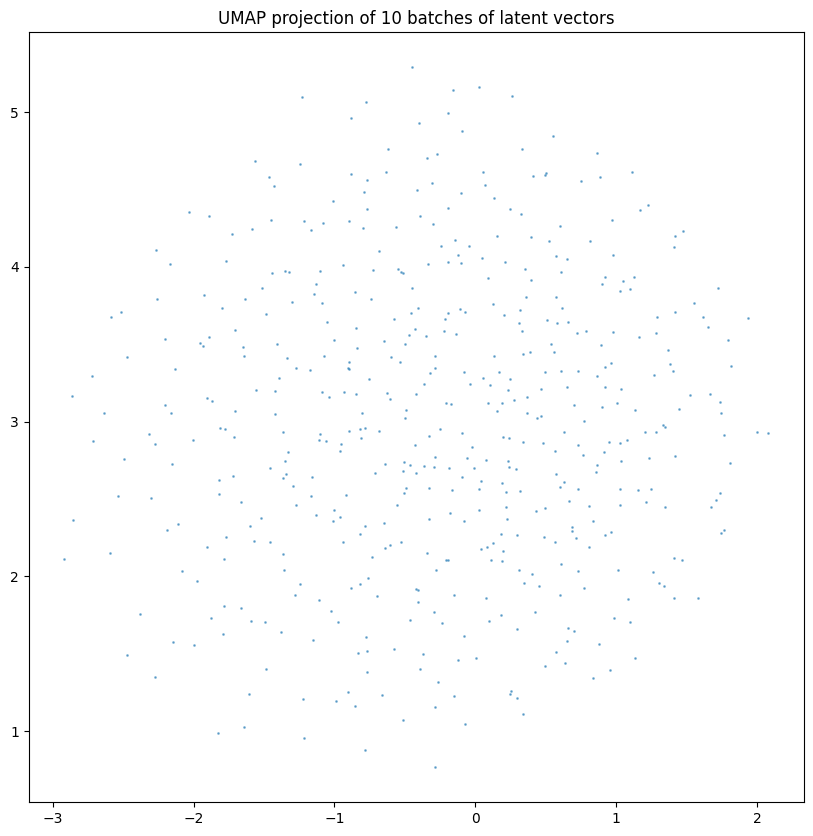

In [22]:
# umap-learn
# pip install umap-learn
import umap
import matplotlib.pyplot as plt
import glob

# Load first N batches
N = 10  # Number of batches to load
batch_files = sorted(glob.glob("sparse_latent_vectors/latent_vectors_batch_*.npy"))[:N]

# Load and concatenate batches
latent_vectors = []
for batch_file in batch_files:
    batch_vectors = np.load(batch_file)
    latent_vectors.append(batch_vectors)
latent_vectors = np.concatenate(latent_vectors, axis=0)

# Remove last 3 columns (sent_idx, tok_idx, token)
latent_vectors = latent_vectors[:, :-3]

print(f"Loaded {len(batch_files)} batches, total shape: {latent_vectors.shape}")

# TODO: do a selection of features (feature of interest, and 100 similar features)

# UMAP dimensionality reduction
umap_embedder = umap.UMAP(n_components=2, metric='cosine')
latent_vectors_2d = umap_embedder.fit_transform(latent_vectors.T)

# Plot
plt.figure(figsize=(10, 10))
plt.scatter(latent_vectors_2d[:, 0], latent_vectors_2d[:, 1], s=1, alpha=0.5)
plt.title(f'UMAP projection of {N} batches of latent vectors')
plt.show()

### Feature specificity

### Feature completness

## Feature search

### Single prompt search

In [25]:
activation_cache = []
def save_activations_hook(module, input, output):
    # input is a tuple; input[0] is the tensor we need
    activation_cache.append(input[0].cpu().detach().numpy())

# Register hook on the 16th layer
layer_index = 15  # Zero-based index; 15 corresponds to the 16th layer
hook_handle = model.model.layers[layer_index].register_forward_hook(save_activations_hook) 

In [30]:
prompt = "in San Francisco, the Golden Gate Bridge was protected at all times by a"

# Tokenize sentence
inputs = tokenizer(
    sentence,
    return_tensors="pt",
    # truncation=True,
    # max_length=512,
    # padding="max_length",
).to(device)

activation_cache = []
# Forward pass
with torch.no_grad():
    model(**inputs)

activations = np.array(activation_cache)
print(f"Activations shape: {activations.shape}") # (1, 1, seq_len, 3072)
activations = activations.squeeze()  # Remove first two dimensions
activations = torch.tensor(activations, dtype=torch.float32)  # Convert to torch tensor with float16 dtype

# Get latent vector for sentence
with torch.no_grad():
    _, encoded = model_sae(activations)
    latent_vector = encoded.cpu().numpy() # (seq_len, 1M)

# Apply row softmax normalization
row_softmax = torch.nn.functional.softmax(torch.tensor(latent_vector), dim=1).numpy()

# Sum over sequence length dimension to get feature importance across sentence
feature_importance = np.sum(row_softmax, axis=0)

# Get top 5 features and their values
top_k = 5
top_feature_indices = np.argsort(feature_importance)[-top_k:][::-1]
top_feature_values = feature_importance[top_feature_indices]

print("Top 5 features and their activation values:")
for idx, val in zip(top_feature_indices, top_feature_values):
    print(f"Feature {idx}: {val:.4f}")



Activations shape: (1, 1, 11, 3072)
Top 5 features and their activation values:
Feature 246: 0.2927
Feature 63: 0.2336
Feature 471: 0.1375
Feature 69: 0.1166
Feature 210: 0.0901


Multiple prompts:
 * tokenize to fixed length
 * reshape activations to (num_sent*seq_len, 3072)
 * get attention mask and remove padding tokens
 


In [31]:
prompts = [
    "in San Francisco, the Golden Gate Bridge was protected at all times by a",
    "the Golden Gate Bridge is so beautiful during the sunset", 
    "Golden Gate Bridge wind resistance barriers creates eerie sound"
]

# Tokenize sentences
inputs = tokenizer(
    prompts,
    return_tensors="pt",
    truncation=True,
    max_length=512,
    padding="max_length",
).to(device)

activation_cache = []
# Forward pass
with torch.no_grad():
    model(**inputs)

activations = np.array(activation_cache)
print(f"Activations shape: {activations.shape}") # (1, num_sent, seq_len, 3072)

# Reshape activations to (num_sent*seq_len, 3072)
activations = activations.squeeze(0)  # Remove batch dimension
num_sent, seq_len, hidden_dim = activations.shape
activations = activations.reshape(-1, hidden_dim)

# Get attention mask and remove padding tokens
attention_mask = inputs['attention_mask'].view(-1).cpu().numpy()
activations = activations[attention_mask == 1]

activations = torch.tensor(activations, dtype=torch.float32)  # Convert to torch tensor

# Get latent vectors for sentences
with torch.no_grad():
    _, encoded = model_sae(activations)
    latent_vector = encoded.cpu().numpy()

# Apply row softmax normalization
row_softmax = torch.nn.functional.softmax(torch.tensor(latent_vector), dim=1).numpy()

# Sum over sequence length dimension to get feature importance across all sentences
feature_importance = np.sum(row_softmax, axis=0)

# Get top 5 features and their values
top_k = 5
top_feature_indices = np.argsort(feature_importance)[-top_k:][::-1]
top_feature_values = feature_importance[top_feature_indices]

print("Top 5 features and their activation values:")
for idx, val in zip(top_feature_indices, top_feature_values):
    print(f"Feature {idx}: {val:.4f}")


Activations shape: (1, 3, 512, 3072)
Top 5 features and their activation values:
Feature 246: 0.8910
Feature 63: 0.7081
Feature 471: 0.4210
Feature 69: 0.3575
Feature 210: 0.2798


### Prompt combination

add negative prompts

### Generated prompts

In [30]:
# use single/multiple prompt search code above
# prompts generated by LLM
